In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

number of all smiles:  133885
number of successfully processed smiles:  133885


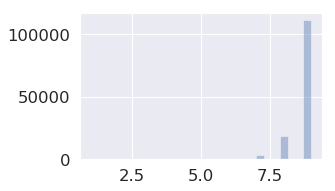

In [3]:
task_name = 'qm9'
tasks = [
   "mu","alpha","homo","lumo","gap","r2","zpve","u0","u298","h298","g298","cv"
]

raw_filename = "../data/qm9.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)

smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [4]:
random_seed = 888 
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 500
epochs = 300

p_dropout= 0.5
fingerprint_dim = 280

weight_decay = 4.9 # also known as l2_regularization_lambda
learning_rate = 3.4
radius = 2
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num


In [5]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

C
N
O
feature dicts file saved as ../data/qm9.pickle


,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom,cano_smiles
0,gdb_1,C,157.71180,157.70997,157.70699,0.0000,13.21,-0.3877,0.1171,0.5048,...,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772,C
1,gdb_2,N,293.60975,293.54111,191.39397,1.6256,9.46,-0.2570,0.0829,0.3399,...,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802,N
2,gdb_3,O,799.58812,437.90386,282.94545,1.8511,6.31,-0.2928,0.0687,0.3615,...,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171,O


In [6]:
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    test_df[task+'_normalized'] = (test_df[task]- mean)/std

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,mu,2.705515,1.531188,1.189853,1.286872
1,alpha,75.185527,8.180522,6.300819,1.298327
2,homo,-0.239966,0.022120,0.016288,1.358023
3,lumo,0.011126,0.046951,0.038650,1.214753
4,gap,0.251092,0.047534,0.039677,1.198034
5,r2,1188.891197,278.813211,201.628922,1.382804
6,zpve,0.148492,0.033272,0.026457,1.257577
7,u0,-411.514595,40.046114,31.089048,1.288110
8,u298,-411.506127,40.045897,31.088914,1.288109
9,h298,-411.505182,40.045897,31.088914,1.288109


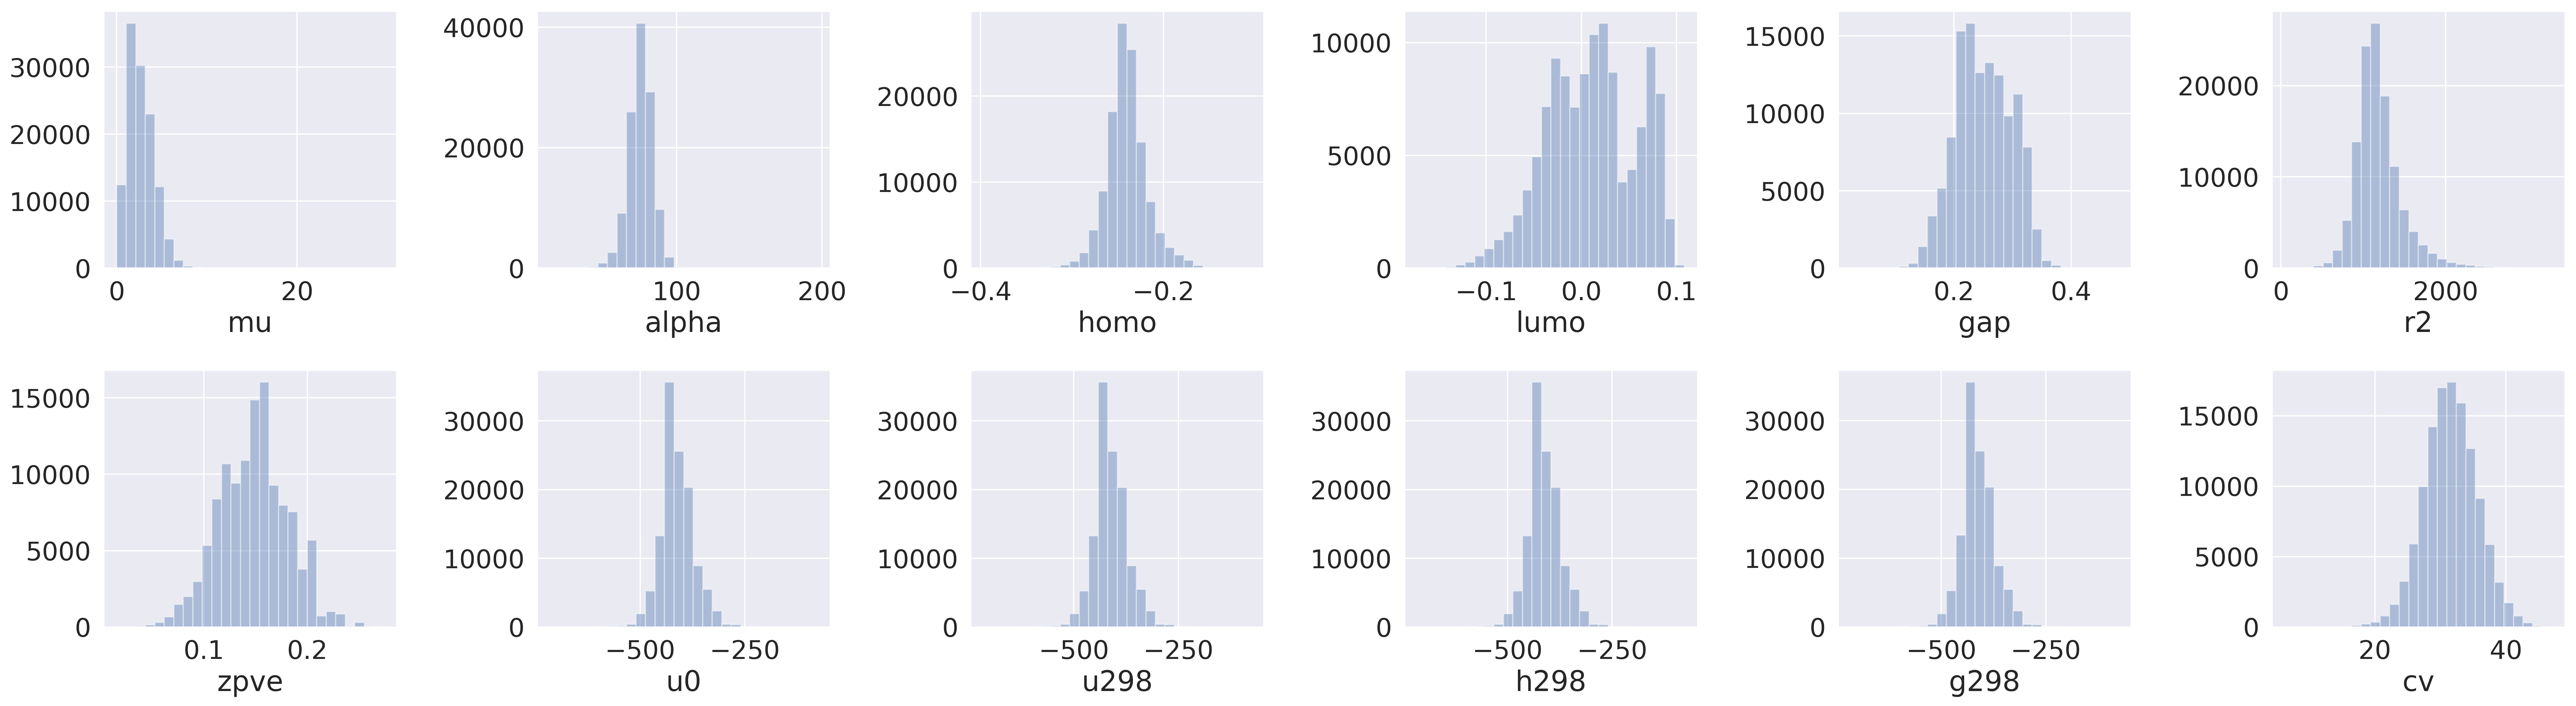

In [7]:
# check the value distribution of different tasks
plt.figure(figsize=(28, 8),dpi=300)
gs = gridspec.GridSpec(2, 6)
sns.set(font_scale=1.8)
for i, task in enumerate(tasks):
    plt.subplot(gs[(i)])
    x = pd.Series(training_data[task].values, name=task)
    ax = sns.distplot(x, bins=28, kde=False)
    plt.tight_layout()
plt.show()
plt.close()

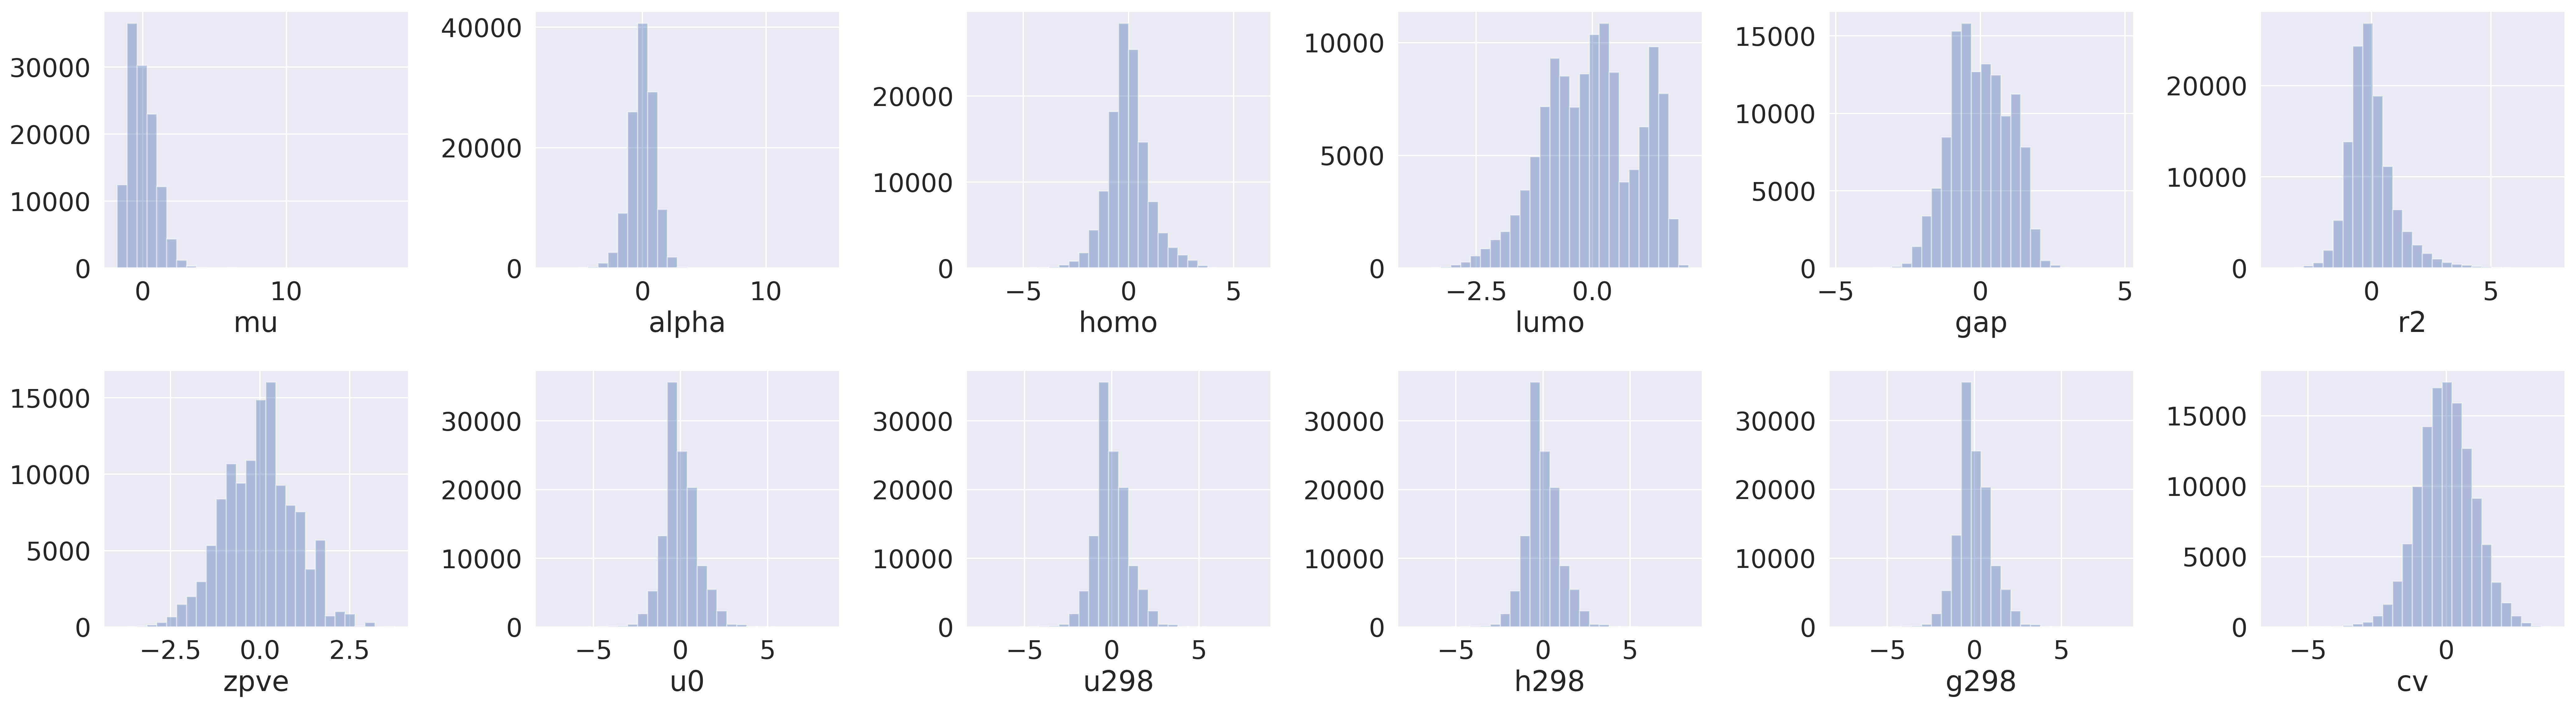

In [8]:
# check the distribution after normalization (should be the same)

plt.figure(figsize=(28, 8),dpi=300)
gs = gridspec.GridSpec(2, 6)
sns.set(font_scale=1.8)
for i, task in enumerate(tasks):
    plt.subplot(gs[(i)])
    x = pd.Series(training_data[task+"_normalized"].values, name=task)
    ax = sns.distplot(x, bins=28, kde=False)
    plt.tight_layout()
plt.show()
plt.close()

In [9]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[8]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
# loss_function = nn.L1Loss()
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1682535
atom_fc.weight torch.Size([280, 39])
atom_fc.bias torch.Size([280])
neighbor_fc.weight torch.Size([280, 49])
neighbor_fc.bias torch.Size([280])
GRUCell.0.weight_ih torch.Size([840, 280])
GRUCell.0.weight_hh torch.Size([840, 280])
GRUCell.0.bias_ih torch.Size([840])
GRUCell.0.bias_hh torch.Size([840])
GRUCell.1.weight_ih torch.Size([840, 280])
GRUCell.1.weight_hh torch.Size([840, 280])
GRUCell.1.bias_ih torch.Size([840])
GRUCell.1.bias_hh torch.Size([840])
align.0.weight torch.Size([1, 560])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 560])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([280, 280])
attend.0.bias torch.Size([280])
attend.1.weight torch.Size([280, 280])
attend.1.bias torch.Size([280])
mol_GRUCell.weight_ih torch.Size([840, 280])
mol_GRUCell.weight_hh torch.Size([840, 280])
mol_GRUCell.bias_ih torch.Size([840])
mol_GRUCell.bias_hh torch.Size([840])
mol_align.weight torch.Size([1, 560])
mol_align.bias torch.Size([1])
mol_attend.weight torch.S

In [10]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
        
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))

        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i]
            y_val = batch_df[task+"_normalized"].values
            loss += loss_function(y_pred, torch.Tensor(y_val).squeeze())*ratio_list[i]**2
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    eval_MAE_list = {}
    eval_MSE_list = {}
    y_val_list = {}
    y_pred_list = {}
    for i,task in enumerate(tasks):
        y_pred_list[task] = np.array([])
        y_val_list[task] = np.array([])
        eval_MAE_list[task] = np.array([])
        eval_MSE_list[task] = np.array([])
        
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
            
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i]
            y_val = batch_df[task+"_normalized"].values
            
            MAE = F.l1_loss(y_pred, torch.Tensor(y_val).squeeze(), reduction='none')        
            MSE = F.mse_loss(y_pred, torch.Tensor(y_val).squeeze(), reduction='none')
            y_pred_list[task] = np.concatenate([y_pred_list[task], y_pred.cpu().detach().numpy()])
            y_val_list[task] = np.concatenate([y_val_list[task], y_val])
            eval_MAE_list[task] = np.concatenate([eval_MAE_list[task],MAE.data.squeeze().cpu().numpy()])
            eval_MSE_list[task] = np.concatenate([eval_MSE_list[task],MSE.data.squeeze().cpu().numpy()])
#     r2_score_list = [r2_score(y_val_list[task], y_pred_list[task]) for task in tasks]
    eval_MAE_normalized = np.array([eval_MAE_list[task].mean() for i, task in enumerate(tasks)])
    eval_MAE = np.multiply(eval_MAE_normalized,np.array(std_list))
    eval_MSE_normalized = np.array([eval_MSE_list[task].mean() for i, task in enumerate(tasks)])
    eval_MSE = np.multiply(eval_MSE_normalized,np.array(std_list))

    return eval_MAE_normalized, eval_MAE, eval_MSE_normalized, eval_MSE #, r2_score_list


In [11]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE_normalized"] = 9e8
best_param["valid_MSE_normalized"] = 9e8
for epoch in range(300):
    train(model, train_df, optimizer, loss_function)
    train_MAE_normalized, train_MAE, train_MSE_normalized, train_MSE = eval(model, train_df)
    valid_MAE_normalized, valid_MAE, valid_MSE_normalized, valid_MSE, = eval(model, valid_df)
    print("EPOCH:\t"+str(epoch)+'\n'\
#         +"train_MAE_normalized: "+str(train_MAE_normalized)+'\n'\
#         +"valid_MAE_normalized: "+str(valid_MAE_normalized)+'\n'\
        +"train_MAE"+":"+"\n"+str(train_MAE)+'\n'\
        +"valid_MAE"+":"+"\n"+str(valid_MAE)+'\n'\
          
        +"train_MSE_normalized_mean: "+str(train_MSE_normalized.mean())+'\n'\
        +"valid_MSE_normalized_mean: "+str(valid_MSE_normalized.mean())+'\n'\
#         +"train_MSE_normalized: "+str(train_MSE_normalized)+'\n'\
#         +"valid_MSE_normalized: "+str(valid_MSE_normalized)+'\n'\
        )
    if train_MSE_normalized.mean() < best_param["train_MSE_normalized"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE_normalized"] = train_MSE_normalized.mean()
    if valid_MSE_normalized.mean() < best_param["valid_MSE_normalized"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE_normalized"] = valid_MSE_normalized.mean()
        if valid_MSE_normalized.mean() < 0.06:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
    


EPOCH:	0
train_MAE:
[8.35835931e-01 1.61693701e+00 9.23091696e-03 1.43035938e-02
 1.68974420e-02 8.15661542e+01 4.21341746e-03 4.05506318e+00
 3.87812842e+00 4.39034017e+00 4.38917412e+00 6.93836554e-01]
valid_MAE:
[8.33503360e-01 1.62585685e+00 9.24397146e-03 1.43354406e-02
 1.70570860e-02 8.17175485e+01 4.18890475e-03 4.06175851e+00
 3.88700944e+00 4.39700843e+00 4.40007302e+00 6.87210501e-01]
train_MSE_normalized_mean: 0.1361972991004328
valid_MSE_normalized_mean: 0.13727252454953537

EPOCH:	1
train_MAE:
[7.61801080e-01 1.11710211e+00 8.39817550e-03 1.08479253e-02
 1.34062402e-02 6.36922811e+01 2.73246863e-03 1.69005672e+00
 1.90872004e+00 1.85645448e+00 1.79736378e+00 5.37503521e-01]
valid_MAE:
[7.61143297e-01 1.11633671e+00 8.41066121e-03 1.08994023e-02
 1.35707689e-02 6.39683049e+01 2.73216329e-03 1.68650169e+00
 1.90349077e+00 1.85309101e+00 1.79306320e+00 5.33574793e-01]
train_MSE_normalized_mean: 0.09760031129959622
valid_MSE_normalized_mean: 0.09855827705088849

EPOCH:	2
trai

EPOCH:	17
train_MAE:
[6.18133013e-01 7.37911214e-01 5.95171366e-03 6.43590032e-03
 8.62375158e-03 4.19685905e+01 1.56024634e-03 9.91628321e-01
 9.92060832e-01 9.92017878e-01 9.92349801e-01 3.67706729e-01]
valid_MAE:
[6.20144026e-01 7.41765661e-01 6.00832000e-03 6.44359235e-03
 8.66323535e-03 4.25333480e+01 1.55666015e-03 1.00323968e+00
 1.00370149e+00 1.00364883e+00 1.00397870e+00 3.66074490e-01]
train_MSE_normalized_mean: 0.054740920696793566
valid_MSE_normalized_mean: 0.05583565932741937

EPOCH:	18
train_MAE:
[5.96431206e-01 6.50338426e-01 5.74734028e-03 6.48539599e-03
 8.59383031e-03 4.10795134e+01 1.33839068e-03 2.51699080e+00
 2.51546495e+00 2.51165228e+00 2.51393066e+00 3.48115234e-01]
valid_MAE:
[5.99522685e-01 6.52628470e-01 5.79986030e-03 6.48641086e-03
 8.62724799e-03 4.15675688e+01 1.33119174e-03 2.52770744e+00
 2.52613161e+00 2.52216469e+00 2.52454566e+00 3.44997612e-01]
train_MSE_normalized_mean: 0.053567848429425156
valid_MSE_normalized_mean: 0.05456328528809523

EPOCH:	1

EPOCH:	34
train_MAE:
[5.68370107e-01 6.61278906e-01 5.19825943e-03 5.68814114e-03
 7.91022280e-03 3.56339928e+01 1.02198418e-03 1.16556155e+00
 1.16558361e+00 1.16557723e+00 1.16556694e+00 3.09140475e-01]
valid_MAE:
[5.70742194e-01 6.67905667e-01 5.26138174e-03 5.75226192e-03
 7.95275319e-03 3.62276569e+01 1.02250663e-03 1.16963154e+00
 1.16965442e+00 1.16964767e+00 1.16963631e+00 3.07011367e-01]
train_MSE_normalized_mean: 0.045604952410083416
valid_MSE_normalized_mean: 0.0471250254715288

EPOCH:	35
train_MAE:
[5.56405420e-01 5.98231360e-01 5.02268951e-03 5.61732348e-03
 7.43218785e-03 3.55772638e+01 1.11117976e-03 1.20011820e+00
 1.20008829e+00 1.20009089e+00 1.20020000e+00 3.05402854e-01]
valid_MAE:
[5.60045338e-01 6.04235962e-01 5.09171007e-03 5.65382723e-03
 7.42646150e-03 3.62356204e+01 1.11757420e-03 1.19154504e+00
 1.19151762e+00 1.19152022e+00 1.19162578e+00 3.04014706e-01]
train_MSE_normalized_mean: 0.04378900140012051
valid_MSE_normalized_mean: 0.04536929650567174

EPOCH:	36


EPOCH:	51
train_MAE:
[5.47777295e-01 6.62990095e-01 4.67451523e-03 4.97723999e-03
 6.82139618e-03 3.41882184e+01 9.16052650e-04 1.04990475e+00
 1.04990417e+00 1.04990384e+00 1.04990427e+00 2.91678982e-01]
valid_MAE:
[5.51502745e-01 6.73386800e-01 4.77184088e-03 5.03152845e-03
 6.89424920e-03 3.49450316e+01 9.19199869e-04 1.04164869e+00
 1.04164736e+00 1.04164718e+00 1.04164764e+00 2.90140499e-01]
train_MSE_normalized_mean: 0.03974232073427824
valid_MSE_normalized_mean: 0.04188430821043814

EPOCH:	52
train_MAE:
[5.81067296e-01 5.70532997e-01 4.69326593e-03 5.12564519e-03
 6.80882441e-03 3.30655936e+01 1.07650319e-03 1.29086163e+00
 1.29085296e+00 1.29085273e+00 1.29089231e+00 2.92346171e-01]
valid_MAE:
[5.86021274e-01 5.78383490e-01 4.79733711e-03 5.18273734e-03
 6.88589027e-03 3.38310772e+01 1.07940237e-03 1.29709943e+00
 1.29708729e+00 1.29708704e+00 1.29714040e+00 2.91591343e-01]
train_MSE_normalized_mean: 0.04155112876365965
valid_MSE_normalized_mean: 0.04363587793129062

EPOCH:	53


EPOCH:	68
train_MAE:
[5.13539901e-01 6.16855750e-01 4.62743092e-03 5.15071972e-03
 6.53843831e-03 3.63987850e+01 1.08855791e-03 3.46339759e+00
 3.46334264e+00 3.46334256e+00 3.46351245e+00 3.05114352e-01]
valid_MAE:
[5.20797721e-01 6.27339212e-01 4.76661511e-03 5.20983402e-03
 6.66220388e-03 3.70974924e+01 1.07852473e-03 3.46265802e+00
 3.46260347e+00 3.46260333e+00 3.46276818e+00 3.04940886e-01]
train_MSE_normalized_mean: 0.039974899652778645
valid_MSE_normalized_mean: 0.04335985763838283

EPOCH:	69
train_MAE:
[5.07510950e-01 6.13400225e-01 4.56901402e-03 5.21141386e-03
 6.49674659e-03 3.22994535e+01 1.23513002e-03 1.74211568e+00
 1.74210654e+00 1.74210656e+00 1.74212119e+00 2.91436813e-01]
valid_MAE:
[5.15862470e-01 6.21631327e-01 4.70642833e-03 5.27604987e-03
 6.63900517e-03 3.30235177e+01 1.23566188e-03 1.75629557e+00
 1.75628424e+00 1.75628427e+00 1.75630651e+00 2.92603030e-01]
train_MSE_normalized_mean: 0.03653417590059399
valid_MSE_normalized_mean: 0.03996063903424601

EPOCH:	70

EPOCH:	85
train_MAE:
[4.78402609e-01 6.32213784e-01 4.38917518e-03 4.78988013e-03
 6.13425164e-03 3.27240071e+01 1.62934040e-03 1.34672583e+00
 1.34671301e+00 1.34671297e+00 1.34673738e+00 2.92370590e-01]
valid_MAE:
[4.94270591e-01 6.44021582e-01 4.57992697e-03 4.86370455e-03
 6.28717681e-03 3.35877920e+01 1.63280273e-03 1.34369008e+00
 1.34367760e+00 1.34367759e+00 1.34370343e+00 2.93184840e-01]
train_MSE_normalized_mean: 0.03305699120050838
valid_MSE_normalized_mean: 0.037837691640997324

EPOCH:	86
train_MAE:
[4.92927425e-01 7.07573000e-01 4.38335525e-03 4.57797845e-03
 6.09682840e-03 3.45101915e+01 1.12585652e-03 3.22473453e+00
 3.22469645e+00 3.22469645e+00 3.22480768e+00 3.06773292e-01]
valid_MAE:
[5.07894359e-01 7.17709039e-01 4.59543362e-03 4.66338829e-03
 6.32457775e-03 3.54649181e+01 1.12061785e-03 3.22449448e+00
 3.22445648e+00 3.22445648e+00 3.22456387e+00 3.07723027e-01]
train_MSE_normalized_mean: 0.035607256683092295
valid_MSE_normalized_mean: 0.04055134776179412

EPOCH:	8

EPOCH:	102
train_MAE:
[4.70319951e-01 5.41327310e-01 4.00479615e-03 4.42034853e-03
 5.78700592e-03 3.06660542e+01 1.28347455e-03 1.25499581e+00
 1.25501630e+00 1.25501629e+00 1.25498467e+00 3.00664790e-01]
valid_MAE:
[4.90306133e-01 5.56609574e-01 4.22885479e-03 4.54140293e-03
 6.00287912e-03 3.16864429e+01 1.28787257e-03 1.26404214e+00
 1.26406221e+00 1.26406217e+00 1.26403391e+00 3.01992970e-01]
train_MSE_normalized_mean: 0.029916205327692985
valid_MSE_normalized_mean: 0.03579729146242238

EPOCH:	103
train_MAE:
[4.66966634e-01 5.22722122e-01 3.98072255e-03 4.41543347e-03
 5.77569405e-03 3.05976380e+01 1.24815589e-03 1.12590573e+00
 1.12595385e+00 1.12595384e+00 1.12581581e+00 2.82533120e-01]
valid_MAE:
[4.86937843e-01 5.35807750e-01 4.20757698e-03 4.51341385e-03
 5.98346175e-03 3.16313131e+01 1.24151820e-03 1.13642539e+00
 1.13647598e+00 1.13647594e+00 1.13632854e+00 2.84433144e-01]
train_MSE_normalized_mean: 0.029560196880312712
valid_MSE_normalized_mean: 0.03511036054288374

EPOCH:

EPOCH:	119
train_MAE:
[4.50136903e-01 5.23341289e-01 4.02981196e-03 4.61854285e-03
 5.86513235e-03 2.89575476e+01 1.30621915e-03 2.51855836e+00
 2.51854220e+00 2.51854228e+00 2.51859475e+00 2.51737045e-01]
valid_MAE:
[4.76096284e-01 5.41371359e-01 4.28919653e-03 4.75191351e-03
 6.13023829e-03 3.02367353e+01 1.30804017e-03 2.52420704e+00
 2.52419103e+00 2.52419112e+00 2.52423904e+00 2.56106547e-01]
train_MSE_normalized_mean: 0.028997468742764158
valid_MSE_normalized_mean: 0.03628085493358854

EPOCH:	120
train_MAE:
[4.49495801e-01 6.77162720e-01 4.09897187e-03 4.41424721e-03
 5.84120010e-03 2.97419542e+01 1.69197553e-03 2.36716643e+00
 2.36711285e+00 2.36711282e+00 2.36722016e+00 3.55872028e-01]
valid_MAE:
[4.76162552e-01 6.88516783e-01 4.33697813e-03 4.55033405e-03
 6.09472631e-03 3.09915318e+01 1.69680993e-03 2.36304819e+00
 2.36299506e+00 2.36299503e+00 2.36310173e+00 3.56832728e-01]
train_MSE_normalized_mean: 0.02974217773878649
valid_MSE_normalized_mean: 0.036684103702229715

EPOCH:

EPOCH:	136
train_MAE:
[4.40381876e-01 5.24165313e-01 3.73404402e-03 4.16928636e-03
 5.33990043e-03 2.90552912e+01 1.10658025e-03 1.01834409e+00
 1.01835156e+00 1.01835158e+00 1.01835120e+00 2.44297356e-01]
valid_MAE:
[4.74463552e-01 5.42153618e-01 4.00179140e-03 4.32093643e-03
 5.64000265e-03 3.04184438e+01 1.10392813e-03 1.02467372e+00
 1.02467981e+00 1.02467986e+00 1.02468395e+00 2.48028409e-01]
train_MSE_normalized_mean: 0.025478878002003515
valid_MSE_normalized_mean: 0.033323520245422754

EPOCH:	137
train_MAE:
[4.36659665e-01 5.02465604e-01 3.73812667e-03 4.21354448e-03
 5.42693847e-03 3.02874215e+01 1.15055429e-03 9.62155345e-01
 9.62135298e-01 9.62135241e-01 9.62187507e-01 2.29984379e-01]
valid_MAE:
[4.69727658e-01 5.17075005e-01 4.01329911e-03 4.36729643e-03
 5.74019318e-03 3.14553008e+01 1.15004516e-03 9.67902910e-01
 9.67880254e-01 9.67880190e-01 9.67938180e-01 2.32818514e-01]
train_MSE_normalized_mean: 0.025527014180688354
valid_MSE_normalized_mean: 0.03349776158342784

EPOCH

EPOCH:	153
train_MAE:
[4.32508368e-01 5.41899206e-01 3.67564569e-03 4.19194637e-03
 5.41143948e-03 2.85384395e+01 1.08940978e-03 1.13244255e+00
 1.13245470e+00 1.13245471e+00 1.13242818e+00 2.49166748e-01]
valid_MAE:
[4.69516382e-01 5.60565596e-01 3.96910826e-03 4.40536695e-03
 5.76480142e-03 2.99710730e+01 1.09003543e-03 1.12981675e+00
 1.12982490e+00 1.12982495e+00 1.12980763e+00 2.53865937e-01]
train_MSE_normalized_mean: 0.02454291800822179
valid_MSE_normalized_mean: 0.033394448705934596

EPOCH:	154
train_MAE:
[4.20682542e-01 5.37440503e-01 3.64825713e-03 4.21939781e-03
 5.34573297e-03 2.89500756e+01 1.11991412e-03 1.03763093e+00
 1.03764872e+00 1.03764867e+00 1.03757715e+00 2.58144469e-01]
valid_MAE:
[4.60667429e-01 5.56125697e-01 3.94916393e-03 4.42553340e-03
 5.70421793e-03 3.04207898e+01 1.11062020e-03 1.04077513e+00
 1.04079556e+00 1.04079553e+00 1.04071605e+00 2.63229552e-01]
train_MSE_normalized_mean: 0.02426411848521287
valid_MSE_normalized_mean: 0.03356312873803191

EPOCH:	

EPOCH:	170
train_MAE:
[4.12501755e-01 4.71960898e-01 3.85350788e-03 4.11737084e-03
 5.20023592e-03 2.74729998e+01 9.68343917e-04 1.31373109e+00
 1.31371929e+00 1.31371920e+00 1.31376891e+00 2.18280305e-01]
valid_MAE:
[4.61089732e-01 4.90797416e-01 4.20056634e-03 4.31564060e-03
 5.60864545e-03 2.89054962e+01 9.67388487e-04 1.31678423e+00
 1.31677235e+00 1.31677226e+00 1.31682174e+00 2.22865394e-01]
train_MSE_normalized_mean: 0.0232840576449705
valid_MSE_normalized_mean: 0.03359757202361948

EPOCH:	171
train_MAE:
[4.19662990e-01 5.08992165e-01 3.58726994e-03 4.14536810e-03
 5.43233316e-03 2.89606583e+01 1.20706018e-03 1.16126396e+00
 1.16125300e+00 1.16125307e+00 1.16128718e+00 2.66936066e-01]
valid_MAE:
[4.69149678e-01 5.28681958e-01 3.92802578e-03 4.35682277e-03
 5.81764642e-03 3.02806191e+01 1.20865972e-03 1.16284954e+00
 1.16284229e+00 1.16284231e+00 1.16285821e+00 2.69849834e-01]
train_MSE_normalized_mean: 0.02341365895583518
valid_MSE_normalized_mean: 0.033912375981091085

EPOCH:	1

EPOCH:	187
train_MAE:
[4.06367773e-01 5.03250469e-01 3.54115228e-03 4.13337471e-03
 5.02740138e-03 2.78986308e+01 1.11380533e-03 2.48471112e+00
 2.48469444e+00 2.48469438e+00 2.48474132e+00 2.61082278e-01]
valid_MAE:
[4.59549077e-01 5.24745170e-01 3.89836594e-03 4.35533301e-03
 5.46239428e-03 2.94148397e+01 1.11607137e-03 2.46964637e+00
 2.46963081e+00 2.46963074e+00 2.46967721e+00 2.65221232e-01]
train_MSE_normalized_mean: 0.023340695359200442
valid_MSE_normalized_mean: 0.033878839029956705

EPOCH:	188
train_MAE:
[4.02105540e-01 4.58257975e-01 3.38438394e-03 3.92573020e-03
 4.92160935e-03 2.81078998e+01 1.04598537e-03 1.18755956e+00
 1.18751557e+00 1.18751560e+00 1.18762557e+00 2.36470873e-01]
valid_MAE:
[4.54843674e-01 4.78903465e-01 3.74052816e-03 4.12429717e-03
 5.33977693e-03 2.93706242e+01 1.04455390e-03 1.17878896e+00
 1.17874879e+00 1.17874885e+00 1.17884898e+00 2.39899951e-01]
train_MSE_normalized_mean: 0.021324756380092586
valid_MSE_normalized_mean: 0.03176609458866748

EPOCH

EPOCH:	204
train_MAE:
[3.98657981e-01 5.05509928e-01 3.39794716e-03 4.16158422e-03
 5.15094642e-03 2.72756570e+01 1.33777122e-03 1.85715039e+00
 1.85714690e+00 1.85714686e+00 1.85715744e+00 2.39800611e-01]
valid_MAE:
[4.54403875e-01 5.26421123e-01 3.78031796e-03 4.39456253e-03
 5.58134903e-03 2.88360082e+01 1.33224436e-03 1.87014979e+00
 1.87014568e+00 1.87014564e+00 1.87015897e+00 2.47128824e-01]
train_MSE_normalized_mean: 0.021752135668971617
valid_MSE_normalized_mean: 0.0324445445191462

EPOCH:	205
train_MAE:
[3.99936132e-01 5.01341877e-01 3.46632231e-03 4.02374081e-03
 4.88837966e-03 2.88019210e+01 1.14843653e-03 1.79177721e+00
 1.79174518e+00 1.79174524e+00 1.79183534e+00 2.66415235e-01]
valid_MAE:
[4.55956108e-01 5.25148046e-01 3.82954938e-03 4.25638071e-03
 5.34628344e-03 3.04110703e+01 1.14938193e-03 1.79552165e+00
 1.79548985e+00 1.79548986e+00 1.79557274e+00 2.73793389e-01]
train_MSE_normalized_mean: 0.021676035648068845
valid_MSE_normalized_mean: 0.03240284263152333

EPOCH:	

EPOCH:	221
train_MAE:
[3.82189632e-01 4.55075721e-01 3.30863789e-03 3.90624058e-03
 4.92759745e-03 2.64297879e+01 9.94592860e-04 9.12855970e-01
 9.12872689e-01 9.12872684e-01 9.12824566e-01 2.29187270e-01]
valid_MAE:
[4.47943888e-01 4.82253425e-01 3.72117877e-03 4.15362748e-03
 5.39483151e-03 2.80739064e+01 9.94481198e-04 9.17019429e-01
 9.17037759e-01 9.17037780e-01 9.16975485e-01 2.36024182e-01]
train_MSE_normalized_mean: 0.019519332972391338
valid_MSE_normalized_mean: 0.031932837816223206

EPOCH:	222
train_MAE:
[3.87157455e-01 6.48414059e-01 3.34015143e-03 3.82318775e-03
 4.92147643e-03 2.82876023e+01 1.14573935e-03 2.28029180e+00
 2.28026955e+00 2.28026956e+00 2.28033411e+00 2.58935724e-01]
valid_MAE:
[4.49147066e-01 6.68933898e-01 3.73564195e-03 4.07812363e-03
 5.38762091e-03 2.98798702e+01 1.16663187e-03 2.28671636e+00
 2.28669365e+00 2.28669367e+00 2.28676453e+00 2.64907640e-01]
train_MSE_normalized_mean: 0.0214276741743842
valid_MSE_normalized_mean: 0.033600201601319685

EPOCH:

EPOCH:	238
train_MAE:
[3.77268504e-01 4.91943937e-01 3.32687047e-03 3.87909486e-03
 4.91519320e-03 2.76537645e+01 1.01633863e-03 2.01526898e+00
 2.01524762e+00 2.01524764e+00 2.01529954e+00 2.51961406e-01]
valid_MAE:
[4.47298702e-01 5.16810808e-01 3.73378509e-03 4.15571921e-03
 5.44033605e-03 2.95682339e+01 1.02502759e-03 2.01312818e+00
 2.01310560e+00 2.01310562e+00 2.01316505e+00 2.59013582e-01]
train_MSE_normalized_mean: 0.020084818550589155
valid_MSE_normalized_mean: 0.032558470252257624

EPOCH:	239
train_MAE:
[3.79090253e-01 4.93705127e-01 3.22155987e-03 3.73460049e-03
 4.71365665e-03 2.76373786e+01 1.38648357e-03 8.18446148e-01
 8.18420092e-01 8.18420118e-01 8.18516796e-01 2.38033264e-01]
valid_MAE:
[4.48872914e-01 5.20290269e-01 3.63128643e-03 3.99292596e-03
 5.22778711e-03 2.94558572e+01 1.39580684e-03 8.22265263e-01
 8.22241098e-01 8.22241138e-01 8.22335982e-01 2.44629244e-01]
train_MSE_normalized_mean: 0.019205804317892813
valid_MSE_normalized_mean: 0.031187059484447263

EPOC

EPOCH:	255
train_MAE:
[3.64798385e-01 5.38561803e-01 3.24127387e-03 3.77157485e-03
 4.84683935e-03 2.59180432e+01 1.06548678e-03 8.37251744e-01
 8.37263648e-01 8.37263647e-01 8.37232256e-01 2.31749880e-01]
valid_MAE:
[4.37699642e-01 5.59006867e-01 3.65003630e-03 4.04406616e-03
 5.37418775e-03 2.79226108e+01 1.07705824e-03 8.30911617e-01
 8.30924761e-01 8.30924780e-01 8.30886446e-01 2.39833801e-01]
train_MSE_normalized_mean: 0.018353829878375874
valid_MSE_normalized_mean: 0.030311154128611784

EPOCH:	256
train_MAE:
[3.69654768e-01 5.44872432e-01 3.22016551e-03 3.96906671e-03
 4.85467835e-03 2.75841924e+01 1.14005263e-03 1.59315776e+00
 1.59314457e+00 1.59314454e+00 1.59319157e+00 2.21368467e-01]
valid_MAE:
[4.44704050e-01 5.72796651e-01 3.68233285e-03 4.28169286e-03
 5.39414151e-03 2.95457705e+01 1.14621055e-03 1.59843515e+00
 1.59842327e+00 1.59842323e+00 1.59846327e+00 2.30474150e-01]
train_MSE_normalized_mean: 0.019603080645715084
valid_MSE_normalized_mean: 0.032954336893112154

EPOC

EPOCH:	272
train_MAE:
[3.57371119e-01 4.43157176e-01 3.17825227e-03 3.70664881e-03
 4.74707938e-03 2.60807349e+01 9.76397347e-04 1.01332546e+00
 1.01331708e+00 1.01331708e+00 1.01331826e+00 2.16435907e-01]
valid_MAE:
[4.38687380e-01 4.70571154e-01 3.64200710e-03 4.00767233e-03
 5.29982035e-03 2.79381198e+01 9.84979907e-04 1.01574960e+00
 1.01574391e+00 1.01574390e+00 1.01573485e+00 2.25012129e-01]
train_MSE_normalized_mean: 0.01763704565514436
valid_MSE_normalized_mean: 0.030278693253367076

EPOCH:	273
train_MAE:
[3.59016561e-01 5.51949179e-01 3.18107361e-03 3.73155634e-03
 4.65148190e-03 2.59518372e+01 1.61758698e-03 1.41331846e+00
 1.41329221e+00 1.41329218e+00 1.41333636e+00 2.75351431e-01]
valid_MAE:
[4.38060511e-01 5.76471678e-01 3.64836830e-03 4.02590019e-03
 5.22728854e-03 2.78733495e+01 1.63737016e-03 1.41795614e+00
 1.41792704e+00 1.41792702e+00 1.41798149e+00 2.82713707e-01]
train_MSE_normalized_mean: 0.01836431938725884
valid_MSE_normalized_mean: 0.03170637388434289

EPOCH:	

EPOCH:	289
train_MAE:
[3.49485148e-01 4.81625943e-01 3.16051884e-03 3.76440159e-03
 4.78989642e-03 2.56771313e+01 1.12613008e-03 1.02259242e+00
 1.02258730e+00 1.02258729e+00 1.02257397e+00 2.50293513e-01]
valid_MAE:
[4.35799448e-01 5.07715836e-01 3.63553371e-03 4.06659906e-03
 5.36214191e-03 2.76447150e+01 1.13495012e-03 1.01644535e+00
 1.01644378e+00 1.01644378e+00 1.01641744e+00 2.57982602e-01]
train_MSE_normalized_mean: 0.017374474896825753
valid_MSE_normalized_mean: 0.031198342520982372

EPOCH:	290
train_MAE:
[3.48705951e-01 4.75958199e-01 3.15075924e-03 3.73367321e-03
 4.60821871e-03 2.71334426e+01 1.09520136e-03 2.34771150e+00
 2.34768884e+00 2.34768885e+00 2.34774414e+00 2.51771907e-01]
valid_MAE:
[4.35091675e-01 5.00717600e-01 3.62023491e-03 4.05109176e-03
 5.19718924e-03 2.91410554e+01 1.10032816e-03 2.33748065e+00
 2.33745865e+00 2.33745865e+00 2.33750649e+00 2.59070255e-01]
train_MSE_normalized_mean: 0.0183482594326434
valid_MSE_normalized_mean: 0.03174275846785424

EPOCH:	

mu, alpha, homo, lumo, gap, r2, zpve, u0, u298, h298, g298, cv

In [12]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

test_MAE_normalized, test_MAE, test_MSE_normalized, test_MSE, = eval(best_model, test_df)
print("best epoch:"+str(best_param["valid_epoch"])+'\n'\
    +"test_MAE"+":"+"\n"+str(test_MAE)+'\n'\
    +"test_MSE_normalized_mean: "+str(test_MSE_normalized.mean())+'\n'\
    )

best epoch:250
test_MAE:
[4.33775451e-01 4.89481527e-01 3.56204317e-03 4.20727834e-03
 5.29253794e-03 2.68881170e+01 1.19590391e-03 9.03679589e-01
 9.03678341e-01 9.03678370e-01 9.03692206e-01 2.54597339e-01]
test_MSE_normalized_mean: 0.029583034753799725

